Welcome!

This is my attempt at using Fourier transformation to remove noise from a noisy audio file (around 21 seconds)

<ipython-input-53-2bf44701590e>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sampling_rate = librosa.load("sample-10.webm")
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


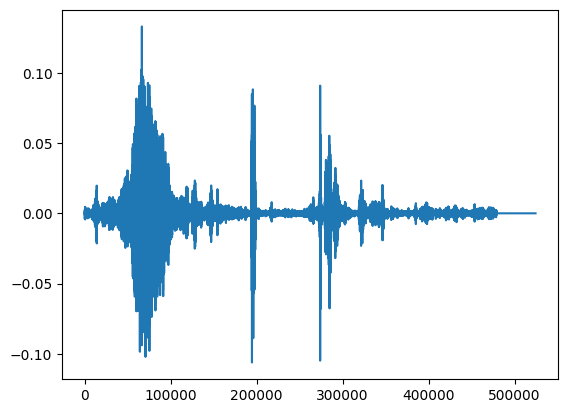

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile

# Use librosa to load the audio file

samples, sampling_rate = librosa.load("sample-10.webm")
N = len(samples)
while not ((N & (N-1) == 0) and N != 0): # using some bitwise trick to check if N is a power of 2, which is required for radix-2 algorithm
        samples = np.pad(samples, (0, 1), 'constant') #if not, pad 0s at the end of the signal until N becomes a power of 2
        N = len(samples)
plt.plot(samples)
plt.show()

In [ ]:
from IPython.display import Audio
wn = Audio('sample-10.webm', autoplay=True)
display(wn)

For this project I will be using Fast Fourier Transformation. Fast Fourier Transformations describes algorithms that computes discrete Fourier transforms (DFT) and its inverse in O(nlogn) time instead of the typical O(n^2) time required to calculate DFT. Specifically, I am using the radix-2 decimation in time algorithm devised by Cooley and Tukey.

The algorithm devides the input into even and odd indices and computes the two separately. The "decimation in time" part just means that the algorithm breaks down the input signal along the time domain into smaller parts. The algorithm runs recursively on each of the halves until it finishes computing the DFT for the entire original input.

Finally, the radix-2 dit algorithm can be described below (source: Wikipedia)

\begin{matrix}X_{k}&=&\sum \limits _{m=0}^{N/2-1}x_{2m}e^{-{\frac {2\pi i}{N}}(2m)k}+\sum \limits _{m=0}^{N/2-1}x_{2m+1}e^{-{\frac {2\pi i}{N}}(2m+1)k}\end{matrix}

Note that the above expression can be simplified many times, but I found it to be the most easily understandable for myself.


In [ ]:
def fft(x): #implementation of the recursive radix-2 algorithm
    x = np.array(x, dtype=float)
    N = int(x.size)
    if N == 1:
        return x
    else:
        k = np.arange(N//2)
        W = np.exp(-2j*np.pi*k/N)
        evens = fft(x[::2])
        odds = fft(x[1::2])
        return np.concatenate([evens + (W * odds), evens - (W * odds)])
    return 0

5.556260885857309
[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


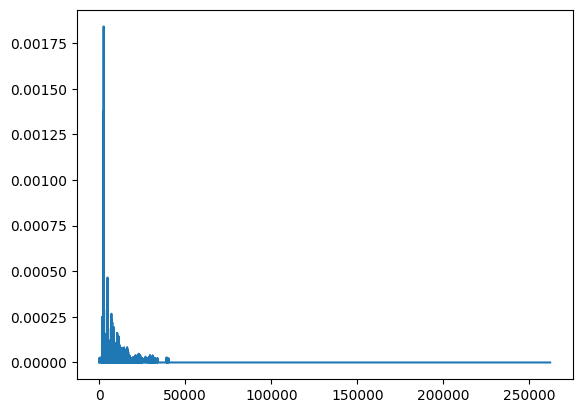

In [ ]:
transformed = fft(samples)
threshold = np.percentile(np.abs(transformed), 95) #only keep signals that are >x% of signals
print(threshold)
transformed[transformed<threshold] = 0
print(transformed)
plt.plot(2.0/len(samples) * np.abs(transformed[:len(samples)//2]))
plt.show()

I can get the filtered signal by computing the inverse of the fft. For sake of simplicity I will use scipy's built in function for this

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


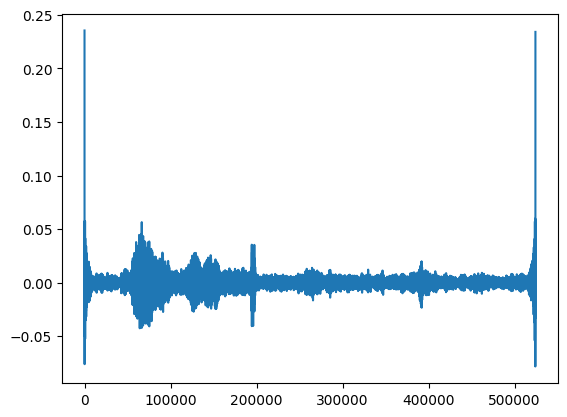

In [ ]:
from scipy.fft import ifft

filtered_signal = ifft(transformed)
plt.plot(filtered_signal)
plt.show()

In [ ]:
scipy.io.wavfile.write('out.wav', sampling_rate,filtered_signal.astype(samples.dtype))

<ipython-input-61-e00ac88f9e3c>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  scipy.io.wavfile.write('out.wav', sampling_rate,filtered_signal.astype(samples.dtype))


In [ ]:
from IPython.display import Audio
wn = Audio('out.wav', autoplay=True)
display(wn)